In [0]:
#===从GCS加载数据
import warnings
warnings.filterwarnings("ignore")

project_id = 'amazing-firefly-153908'
bucket_name = 'nlp_final'

# 获取授权
from google.colab import auth
auth.authenticate_user()

#从GCS下载数据至tmp
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')
from apiclient.http import MediaIoBaseDownload

In [0]:
def download_from_GCS(file_name):
  with open(file_name, 'wb') as f:
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                              object=file_name)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
      # _ is a placeholder for a progress object that we ignore.
      # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()
  print(file_name + ' downloaded')

In [0]:
download_from_GCS('train_ft_all3.csv')
# download_from_GCS('test_ft_all3.csv')

train_ft_all3.csv downloaded


In [0]:
import numpy as np
import pandas as pd
import time
# from tqdm.auto import tqdm
# tqdm.pandas()

import matplotlib
from IPython.display import display # 允许为DataFrame使用display()
%matplotlib inline

import matplotlib.pyplot as plt

In [0]:
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas(desc="my bar!")

In [0]:
def get_time():
  seconds = time.time()
  named_tuple = time.gmtime(seconds) # get struct_time
  hour = named_tuple.tm_hour + 8
  if hour > 24:
    hour = hour - 24
  time_str = str(hour) + ':' + str(named_tuple.tm_min) + ':' + str(named_tuple.tm_sec)
  return time_str

In [0]:
from googleapiclient.http import MediaFileUpload
def upload_to_GCS(file_name):
  media = MediaFileUpload(file_name, 
                          mimetype='text/csv',
                          resumable=True)

  request = gcs_service.objects().insert(bucket=bucket_name, 
                                         name=file_name,
                                         media_body=media)

  response = None
  while response is None:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, response = request.next_chunk()
  print(file_name + ' uploaded')

In [0]:
download_from_GCS('train.csv')
train_data = pd.read_csv('train.csv')
train_data.head()

train.csv downloaded


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
train_label = train_data['is_duplicate']

In [0]:
train3 = pd.read_csv('train_ft_all3.csv')
X_train3 = train3
X_train3 = X_train3.drop('id', axis=1)
X_train3 = X_train3.fillna(0)
X_train3[X_train3==np.inf]=np.nan
X_train3.fillna(X_train3.mean(), inplace=True)

In [0]:
y_train3 = train_label
print(y_train3.value_counts())

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [0]:
p = 149263/404290
print(p)

0.369197853026293


In [0]:
pos_public = (0.55410 + np.log(1 - p)) / np.log((1 - p) / p)
pos_private = (0.55525 + np.log(1 - p)) / np.log((1 - p) / p)
average = (pos_public + pos_private) / 2
print (pos_public, pos_private, average)

0.17424682519173934 0.17639371112774202 0.17532026815974067


In [0]:
w0 = average * (1 - p) / ((1 - average) * p)
print(w0)

0.3632292393086082


In [0]:
w1 = average / p
w2 = (1 - average) / (1 - p)
print(w1, w2)

0.474868059829305 1.3073508639700833


In [0]:
def wt_log_loss(preds, dtrain):
    label = dtrain.get_label()
    return "wt_logloss", -np.mean(w1 * label * np.log(preds) + w2 * (1 - label) * np.log(1 - preds))

In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


In [0]:
! pip install bayesian-optimization

In [0]:
from bayes_opt import BayesianOptimization

In [0]:
# download_from_GCS('train_ft_all3.csv')

# train.head()
# 将'train_ft'和'train_label'切分为训练集和验证集
# X_train, X_val, y_train, y_val = train_test_split(train, train_label, test_size=0.2, random_state=0,
#                                                     stratify = train_label)

# # X_test = test

# # 显示切分的结果
# print ("Training set has {} samples.".format(X_train.shape[0]))
# print ("Validation set has {} samples.".format(X_val.shape[0]))
# # print ("Testing set has {} samples.".format(X_test.shape[0]))


# dtrain3 = xgb.DMatrix(X_train3, label = y_train3)

In [0]:
X_train3.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,cos_glv,...,diff_sen_com,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,repeat,tfidf_cosine_stwd,wmd,norm_wmd,cos_w2v,L1_w2v,canberra_w2v,L2_w2v,minkowski_w2v,braycurtis_w2v,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,q1_freq,q2_freq,q1_q2_freq_average,canberra_glv,minkowski_glv,braycurtis_glv,skew_q1vec_glv,skew_q2vec_glv,kur_q1vec_glv,kur_q2vec_glv,canberra_encode,minkowski_encode,braycurtis_encode,skew_q1vec_encode,skew_q2vec_encode,kur_q1vec_encode,kur_q2vec_encode,same_end_word
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,4.553006,0.269064,0.036198,0.035558,1.791759,0.833333,0.538997,0.205387,0.036422,0.031762,...,0.0000,93,95,100,100,89,100,93,0,0.981789,0.198042,0.198042,0.037908,3.774843,75.949313,0.275348,0.125323,0.137314,0.008893,-0.099771,0.108845,0.344742,1,2,1.5,91.349971,0.114783,0.166479,2.158091,2.455419,25.021147,26.141849,124.261119,0.118751,0.120247,-0.076135,-0.042752,-0.989944,-0.958032,0
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,12.591572,0.724755,0.262635,0.233201,1.609438,0.500000,0.287682,1.101979,0.475765,0.266555,...,0.0000,65,86,73,100,75,86,63,0,0.762118,0.877940,0.877940,0.376926,12.337880,168.641909,0.868246,0.389172,0.498692,0.006689,0.118289,0.185005,0.206283,8,3,5.5,140.639989,0.443313,0.370294,-0.257926,-0.622981,1.543840,20.745921,221.270339,0.309102,0.347132,-0.056110,-0.026842,-0.942674,-1.278017,0
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,7.645729,0.456800,0.104333,0.099242,1.098612,0.333333,0.182322,1.430197,1.447160,0.118900,...,0.0450,54,63,53,100,71,66,66,0,0.276420,0.694896,0.694896,0.215223,8.840496,135.849172,0.656084,0.305829,0.332821,0.247069,0.152550,0.042900,-0.489377,2,1,1.5,129.054466,0.230156,0.286149,1.109940,-0.135832,16.728574,9.117428,163.702191,0.198237,0.202258,-0.035711,0.067302,-1.103482,-1.130741,0
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,22.252520,1.238057,0.766393,0.568940,0.000000,0.000000,0.000000,1.615345,2.000000,0.619671,...,0.2484,36,36,40,37,38,36,36,0,0.000000,1.261312,1.261312,0.635212,15.691485,189.600970,1.127131,0.501912,0.677309,0.013645,0.068055,-0.230252,-0.102497,1,1,1.0,198.947606,0.532528,0.803537,0.898184,2.416472,17.295623,16.170487,325.741225,0.507923,0.757637,-0.073181,-0.100329,-0.788452,-0.822424,0
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.9459

In [0]:
dtrain3 = xgb.DMatrix(X_train3, label = y_train3)

In [0]:
# 特征数 86
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256

model1 = xgb.cv(params, dtrain3, num_boost_round = 300, nfold = 10, 
                feval = wt_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633701+0.000105164	train-wt_logloss:0.622772+0.000127841	test-logloss:0.633788+0.000285149	test-wt_logloss:0.622852+0.000972649
[50]	train-logloss:0.294024+0.000529861	train-wt_logloss:0.187774+0.000289764	test-logloss:0.297743+0.00299221	test-wt_logloss:0.190525+0.00205949
[100]	train-logloss:0.274359+0.000487346	train-wt_logloss:0.174394+0.000329818	test-logloss:0.281857+0.00307448	test-wt_logloss:0.17997+0.00215608
[150]	train-logloss:0.263717+0.000458067	train-wt_logloss:0.167755+0.000318505	test-logloss:0.275219+0.00302926	test-wt_logloss:0.176314+0.00215617
[200]	train-logloss:0.256035+0.000347927	train-wt_logloss:0.162914+0.00024819	test-logloss:0.271544+0.00310085	test-wt_logloss:0.17447+0.00221433
[250]	train-logloss:0.249626+0.000437471	train-wt_logloss:0.158878+0.000304227	test-logloss:0.26897+0.00305204	test-wt_logloss:0.173317+0.00221099
[299]	train-logloss:0.244135+0.000446556	train-wt_logloss:0.155425+0.00028771	test-logloss:0.267229+0.00297222	test-w

In [0]:
# 特征数 优化的参数
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.9997
params["colsample_bytree"] = 0.6009
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256

model1 = xgb.cv(params, dtrain3, num_boost_round = 300, nfold = 10, 
                feval = wt_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633466+0.000104486	train-wt_logloss:0.62253+0.000115848	test-logloss:0.633544+0.000296648	test-wt_logloss:0.622601+0.000992449
[50]	train-logloss:0.295891+0.000474031	train-wt_logloss:0.189026+0.00028797	test-logloss:0.299477+0.002893	test-wt_logloss:0.191667+0.00195987
[100]	train-logloss:0.275453+0.000535476	train-wt_logloss:0.175055+0.000342335	test-logloss:0.282483+0.00289441	test-wt_logloss:0.180307+0.00211372
[150]	train-logloss:0.265748+0.000560662	train-wt_logloss:0.169014+0.00034745	test-logloss:0.276135+0.00288979	test-wt_logloss:0.176768+0.00213489
[200]	train-logloss:0.259015+0.000557103	train-wt_logloss:0.164775+0.000342452	test-logloss:0.272513+0.00290307	test-wt_logloss:0.174851+0.00216168
[250]	train-logloss:0.253765+0.000546235	train-wt_logloss:0.161461+0.000356137	test-logloss:0.270208+0.00290159	test-wt_logloss:0.173727+0.00217797
[299]	train-logloss:0.24927+0.000489103	train-wt_logloss:0.158636+0.000311124	test-logloss:0.268526+0.00294761	test-wt

In [0]:
# 降低学习率
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.9997
params["colsample_bytree"] = 0.6009
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256

model1 = xgb.cv(params, dtrain3, num_boost_round = 4000, nfold = 10, 
                feval = wt_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.680653+2.19693e-05	train-wt_logloss:0.67843+0.000133241	test-logloss:0.680669+6.05818e-05	test-wt_logloss:0.678445+0.00122282
[50]	train-logloss:0.412377+0.000223288	train-wt_logloss:0.339567+0.000125752	test-logloss:0.413172+0.00166397	test-wt_logloss:0.340233+0.000964886
[100]	train-logloss:0.339609+0.000283874	train-wt_logloss:0.243609+0.000186035	test-logloss:0.341115+0.00235149	test-wt_logloss:0.2448+0.00149002
[150]	train-logloss:0.31524+0.000292922	train-wt_logloss:0.210598+0.00019934	test-logloss:0.317435+0.00265213	test-wt_logloss:0.212262+0.00173153
[200]	train-logloss:0.303354+0.00037808	train-wt_logloss:0.196428+0.00025142	test-logloss:0.306174+0.00283483	test-wt_logloss:0.198529+0.00186278
[250]	train-logloss:0.296235+0.000364713	train-wt_logloss:0.189367+0.000242787	test-logloss:0.299651+0.00297782	test-wt_logloss:0.191906+0.00198602
[300]	train-logloss:0.290404+0.000396177	train-wt_logloss:0.18491+0.000264018	test-logloss:0.294532+0.00297697	test-wt_l

In [0]:
# 调节 max_depth min_child_weight
def xgb_evaluate(max_depth, min_child_weight):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': 0,
              'colsample_bytree': 0.9,
              'tree_method':'gpu_hist',
             'scale_pos_weight':w0,
             'max_bin':256}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain3, num_boost_round=150, nfold=10, feval = wt_log_loss) 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-wt_logloss-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight':(1, 5)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

In [0]:
# 特征数 87
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain3, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633589+6.5738e-05	test-logloss:0.633706+0.000292923
[50]	train-logloss:0.254765+0.000288662	test-logloss:0.25874+0.00294974
[100]	train-logloss:0.236001+0.000296305	test-logloss:0.244146+0.00294501
[150]	train-logloss:0.227037+0.000376183	test-logloss:0.239435+0.0028586
[200]	train-logloss:0.220274+0.000261507	test-logloss:0.236806+0.00280262
[250]	train-logloss:0.2147+0.000403167	test-logloss:0.235383+0.00272168
[300]	train-logloss:0.209642+0.000384289	test-logloss:0.234386+0.00272365
[350]	train-logloss:0.204881+0.000252666	test-logloss:0.233704+0.00269396
[400]	train-logloss:0.200557+0.000324713	test-logloss:0.233256+0.00266774
[450]	train-logloss:0.196347+0.000354517	test-logloss:0.232918+0.00272111
[500]	train-logloss:0.192231+0.000321602	test-logloss:0.232632+0.00273271
[550]	train-logloss:0.188344+0.000335513	test-logloss:0.23245+0.00274996
[600]	train-logloss:0.184513+0.000322239	test-logloss:0.232303+0.00275525
[650]	train-logloss:0.180819+0.000386381	test-

In [0]:
# download_from_GCS('test_ft_all3.csv')
test = pd.read_csv('test_ft_all3.csv')
dtest = xgb.DMatrix(test)

In [0]:
download_from_GCS('test.csv')
test_raw = pd.read_csv('test.csv')

test.csv downloaded


In [0]:
test = test.drop('id', axis=1)
test = test.fillna(0)
test[test==np.inf]=np.nan
test.fillna(test.mean(), inplace=True)
dtest = xgb.DMatrix(test)

In [0]:
test.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,cos_glv,...,diff_sen_com,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,repeat,tfidf_cosine_stwd,wmd,norm_wmd,cos_w2v,L1_w2v,canberra_w2v,L2_w2v,minkowski_w2v,braycurtis_w2v,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,q1_freq,q2_freq,q1_q2_freq_average,canberra_glv,minkowski_glv,braycurtis_glv,skew_q1vec_glv,skew_q2vec_glv,kur_q1vec_glv,kur_q2vec_glv,canberra_encode,minkowski_encode,braycurtis_encode,skew_q1vec_encode,skew_q2vec_encode,kur_q1vec_encode,kur_q2vec_encode,same_end_word
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,13.228489,0.784084,0.307394,0.268036,1.386294,0.400000,0.223144,1.487714,1.332189,0.212743,...,0.0000,46,55,45,100,59,58,55,0,0.333906,0.880386,0.880386,0.386389,12.053253,161.856466,0.879077,0.397780,0.480725,0.060989,0.071506,0.206236,-0.317566,1,1,1.0,157.912241,0.297087,0.420838,1.060148,2.278803,14.769823,25.698478,230.459080,0.335352,0.373265,-0.009512,0.000340,-1.244313,-1.233780,0
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,8.212183,0.488314,0.119225,0.112637,1.609438,0.615385,0.367725,1.000223,0.661058,0.082187,...,0.0000,49,86,57,100,64,82,58,0,0.669471,0.421667,0.421667,0.136669,7.267052,120.948289,0.522817,0.234587,0.274652,-0.018201,-0.004014,0.150158,0.010465,2,2,2.0,126.617151,0.200035,0.261458,3.529328,2.363401,37.377708,25.717867,167.320022,0.209699,0.216852,0.043952,0.034034,-1.034802,-1.156297,0
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,9.238203,0.545916,0.149012,0.138903,1.386294,0.600000,0.356675,0.852124,0.390172,0.080816,...,0.7783,59,86,82,100,68,92,55,0,0.804914,0.630674,0.630674,0.204235,9.068271,137.245312,0.639116,0.284338,0.341486,-0.012669,-0.066156,-0.393252,-0.371144,1,1,1.0,112.623821,0.188420,0.246372,0.661936,0.434966,28.877237,12.525225,186.358232,0.234621,0.254429,0.005193,0.023300,-0.798762,-0.700285,0
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,13.437407,0.754944,0.284970,0.250736,0.000000,0.000000,0.000000,1.317023,2.000000,0.391609,...,0.0000,52,53,56,62,62,52,52,0,0.000000,0.918765,0.918765,0.288832,10.312107,153.680880,0.760042,0.349093,0.412119,0.094811,0.069599,-0.150121,0.774025,1,1,1.0,177.057767,0.394867,0.542606,-0.385024,0.079230,2.058123,6.054589,248.603338,0.315308,0.387871,0.054974,0.111906,-0.414613,-1.089561,0
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0

In [0]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.9997
params["colsample_bytree"] = 0.6009
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256

start = time.time()
model3 = xgb.train(params, dtrain3, num_boost_round = 3600)
end = time.time()
train_time = end - start

print("train time: {} s".format(train_time))


train time: 1401.461349248886 s


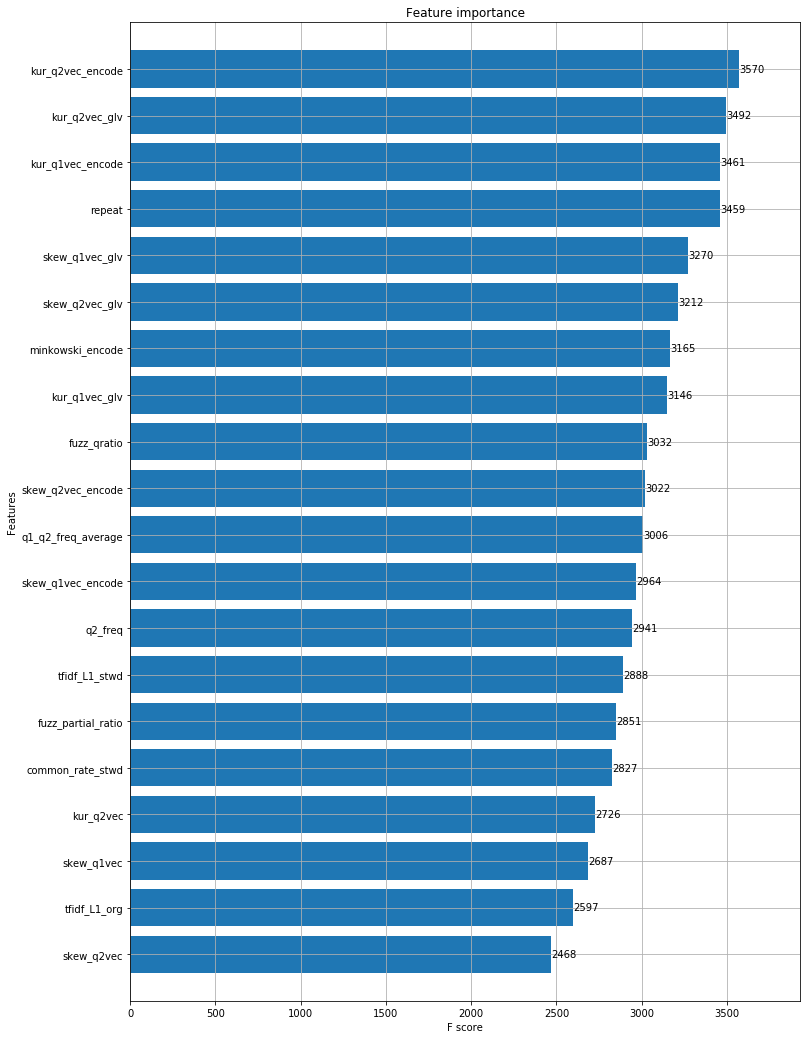

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model3, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
import pickle

pickle.dump(model3, open("model3.pickle", "wb")) #保存 model3

In [0]:
upload_to_GCS("model3.pickle")

model3.pickle uploaded


In [0]:
start = time.time()
prediction = model3.predict(dtest)
end = time.time()
predict_time = end - start
print("predict time: {} s".format(predict_time))

subm = pd.DataFrame()
subm['test_id'] = test_raw['test_id']
subm['is_duplicate'] = prediction
subm.to_csv('submission3600_2.csv', index=False)
print('submission file saved')

predict time: 16.02756929397583 s
submission file saved


In [0]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 3
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params['seed']=0

start = time.time()
model2 = xgb.train(params, dtrain3, num_boost_round = 3600)
end = time.time()
train_time = end - start

print("train time: {} s".format(train_time))

train time: 1103.437370300293 s


In [0]:
start = time.time()
prediction = model2.predict(dtest)
end = time.time()
predict_time = end - start
print("predict time: {} s".format(predict_time))

subm = pd.DataFrame()
subm['test_id'] = test_raw['test_id']
subm['is_duplicate'] = prediction
subm.to_csv('submission3600.csv', index=False)
print('submission file saved')

predict time: 15.823448181152344 s
submission file saved


In [0]:
import pickle

pickle.dump(model2, open("model2.pickle", "wb")) #保存 model2
# embeddings_index = pickle.load(open("embeddings_index.pickle", "rb")) #读取保存的 embeddings_index

In [0]:
upload_to_GCS("model2.pickle")
# download_from_GCS('embeddings_index.pickle')

model2.pickle uploaded


In [0]:
subm.head()

,test_id,is_duplicate
0,0,0.005921
1,1,0.322294
2,2,0.555363
3,3,0.000620
4,4,0.136328


In [0]:
# 调节 max_depth min_child_weight
def xgb_evaluate(max_depth, min_child_weight):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': 0,
              'colsample_bytree': 0.9,
              'tree_method':'gpu_hist',
             'scale_pos_weight':1,
             'max_bin':256,
              'seed':0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain3, num_boost_round=150, nfold=10, metrics='logloss') 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight':(1, 5)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

|   iter    |  target   | max_depth | min_ch... |
-------------------------------------------------
|  1        | -0.2747   |  5.812    |  4.473    |


KeyboardInterrupt: ignored

In [0]:
# 特征数 85
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain3, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633595+6.51513e-05	test-logloss:0.633704+0.000293021
[50]	train-logloss:0.256822+0.000335538	test-logloss:0.260897+0.00287607
[100]	train-logloss:0.238579+0.000547534	test-logloss:0.246904+0.00278904
[150]	train-logloss:0.229292+0.000505628	test-logloss:0.241781+0.0027192
[200]	train-logloss:0.222426+0.000493216	test-logloss:0.239095+0.00260626
[250]	train-logloss:0.216772+0.000480766	test-logloss:0.237529+0.00258983
[300]	train-logloss:0.211669+0.000457548	test-logloss:0.236503+0.00257373
[350]	train-logloss:0.206966+0.000347783	test-logloss:0.235695+0.00259931
[400]	train-logloss:0.20267+0.000427774	test-logloss:0.235265+0.00256795
[450]	train-logloss:0.198399+0.000451339	test-logloss:0.234831+0.00257797
[500]	train-logloss:0.194307+0.000415082	test-logloss:0.234513+0.0025319
[550]	train-logloss:0.190433+0.000443574	test-logloss:0.234295+0.0025931
[600]	train-logloss:0.186631+0.000474552	test-logloss:0.234095+0.00261201
[650]	train-logloss:0.183007+0.000485511	tes

In [0]:
column_list = train.columns

In [0]:
print(column_list)

Index(['len_word_dff_org', 'len_word_dff_rt_org', 'len_char_dff_org',
       'len_char_dff_rt_org', 'common_words_org', 'common_rate_org',
       'jaccard_similarity_org', 'tfidf_L1_org', 'tfidf_L2_org',
       'tfidf_cosine_org', 'len_word_dff_stm', 'len_word_dff_rt_stm',
       'len_char_dff_stm', 'len_char_dff_rt_stm', 'common_words_stm',
       'common_rate_stm', 'jaccard_similarity_stm', 'tfidf_L1_stm',
       'tfidf_L2_stm', 'tfidf_cosine_stm', 'len_word_dff_lmtz',
       'len_word_dff_rt_lmtz', 'len_char_dff_lmtz', 'len_char_dff_rt_lmtz',
       'common_words_lmtz', 'common_rate_lmtz', 'jaccard_similarity_lmtz',
       'tfidf_L1_lmtz', 'tfidf_L2_lmtz', 'tfidf_cosine_lmtz', 'encode_L1',
       'encode_L2', 'encode_cos', 'encode_cos_log', 'common_words_stwd',
       'common_rate_stwd', 'jaccard_similarity_stwd', 'tfidf_L1_stwd',
       'tfidf_L2_stwd', 'cos_glv', 'L1_glv', 'L2_glv', 'same_start_word',
       'diff_sen_neg', 'diff_sen_neu', 'diff_sen_pos', 'diff_sen_com',
       'f

In [0]:
train_2 = train.drop(['len_word_dff_stm', 'len_word_dff_rt_stm',
       'len_char_dff_stm', 'len_char_dff_rt_stm', 'common_words_stm',
       'common_rate_stm', 'jaccard_similarity_stm', 'tfidf_L1_stm',
       'tfidf_L2_stm', 'tfidf_cosine_stm', 'len_word_dff_lmtz',
       'len_word_dff_rt_lmtz', 'len_char_dff_lmtz', 'len_char_dff_rt_lmtz',
       'common_words_lmtz', 'common_rate_lmtz', 'jaccard_similarity_lmtz',
       'tfidf_L1_lmtz', 'tfidf_L2_lmtz', 'tfidf_cosine_lmtz'], axis=1)
train_2.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,cos_glv,L1_glv,L2_glv,same_start_word,diff_sen_neg,diff_sen_neu,diff_sen_pos,diff_sen_com,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,repeat,tfidf_cosine_stwd,wmd,norm_wmd,cos_w2v,L1_w2v,canberra_w2v,L2_w2v,minkowski_w2v,braycurtis_w2v,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,q1_freq,q2_freq,q1_q2_freq_average,canberra_glv,minkowski_glv,braycurtis_glv,skew_q1vec_glv,skew_q2vec_glv,kur_q1vec_glv,kur_q2vec_glv
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,2.133778,0.269064,0.963802,0.674883,1.791759,0.833333,0.538997,0.205387,0.036422,0.031762,3.456409,0.252040,1,0.000,0.022,0.022,0.0000,93,95,100,100,89,100,93,0,0.981789,0.198042,0.198042,0.037908,3.774843,75.949313,0.275348,0.125323,0.137314,0.008893,-0.099771,0.108845,0.344742,1,2,1.5,91.349971,0.114783,0.166479,2.158091,2.455419,25.021147,26.141849
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,3.548461,0.724755,0.737365,0.552370,1.609438,0.500000,0.287682,1.101979,0.475765,0.266555,8.548248,0.730144,1,0.000,0.075,0.075,0.0000,65,86,73,100,75,86,63,0,0.762118,0.877940,0.877940,0.376926,12.337880,168.641909,0.868246,0.389172,0.498692,0.006689,0.118289,0.185005,0.206283,8,3,5.5,140.639989,0.443313,0.370294,-0.257926,-0.622981,1.543840,20.745921
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,2.765091,0.456800,0.895667,0.639571,1.098612,0.333333,0.182322,1.430197,1.447160,0.118900,6.461987,0.487647,1,0.000,0.016,0.016,0.0450,54,63,53,100,71,66,66,0,0.276420,0.694896,0.694896,0.215223,8.840496,135.849172,0.656084,0.305829,0.332821,0.247069,0.152550,0.042900,-0.489377,2,1,1.5,129.054466,0.230156,0.286149,1.109940,-0.135832,16.728574,9.117428
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.000000,0.000000,0.000000,1.615345,2.000000,0.619671,14.745557,1.113257,0,0.241,0.396,0.155,0.2484,36,36,40,37,38,36,36,0,0.000000,1.261312,1.261312,0.635212,15.691485,189.600970,1.127131,0.501912,0.677309,0.013645,0.068055,-0.230252,-0.102497,1,1,1.0,198.947606,0.532528,0.803537,0.898184,2.416472,17.295623,16.170487
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,4.118772,0.973915,0.525745,0.422483,1.098612,0.250000,0.133531,1.649376,1.504143,0.211085,8.885255,0.649746,1,0.000,0.000,0.000,0.0000,45,86,55,100,63,67,46,0,0.247928,0.998063,0.998063,0.333550,11.235840,149.646926,0.816762,0.366127,0.435380,-0.082484,0.074702,-0.237995,-0.360966,3,1,2.0,156.294233,0.299003,0.425088,0.791283,0.917872,13.634911,17.349398


In [0]:
X_train_2 = train_2
y_train_2 = train_label
dtrain_2 = xgb.DMatrix(X_train_2, label = y_train_2)


In [0]:
# drop stm lmtz 特征之后
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain_2, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633904+4.74364e-05	test-logloss:0.634009+0.00029482


In [0]:
# 特征数 78 之后
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.633718+6.64575e-05	test-logloss:0.633831+0.00029447
[50]	train-logloss:0.259569+0.000376819	test-logloss:0.263334+0.00301036
[100]	train-logloss:0.242787+0.000351965	test-logloss:0.250486+0.00304783
[150]	train-logloss:0.234026+0.000254398	test-logloss:0.245843+0.00292573
[200]	train-logloss:0.22739+0.000338739	test-logloss:0.243242+0.00281348
[250]	train-logloss:0.221693+0.000252442	test-logloss:0.241534+0.00277096
[300]	train-logloss:0.216504+0.000317105	test-logloss:0.240384+0.00272041
[350]	train-logloss:0.211827+0.00031869	test-logloss:0.239537+0.00269492
[400]	train-logloss:0.207462+0.000347681	test-logloss:0.238915+0.00261331
[450]	train-logloss:0.203297+0.000340691	test-logloss:0.238475+0.00265159
[500]	train-logloss:0.199215+0.000351405	test-logloss:0.238043+0.00261589
[550]	train-logloss:0.19543+0.000363806	test-logloss:0.237742+0.00263645
[600]	train-logloss:0.191675+0.00036635	test-logloss:0.237506+0.00268936
[650]	train-logloss:0.18818+0.00041828	test-l

In [0]:
# 添加basic features、w2v features 之后
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635568+5.51689e-05	test-logloss:0.635651+0.000248097
[50]	train-logloss:0.279623+0.00038034	test-logloss:0.283199+0.00271804
[100]	train-logloss:0.26575+0.000241161	test-logloss:0.272963+0.00291541
[150]	train-logloss:0.257613+0.000357603	test-logloss:0.268976+0.00288723
[200]	train-logloss:0.251026+0.000286505	test-logloss:0.266556+0.00272874
[250]	train-logloss:0.245476+0.00031435	test-logloss:0.264995+0.0026494
[300]	train-logloss:0.240496+0.000311123	test-logloss:0.263832+0.00262628
[350]	train-logloss:0.235732+0.000323644	test-logloss:0.262979+0.00253015
[400]	train-logloss:0.2315+0.000347169	test-logloss:0.262412+0.00248224
[450]	train-logloss:0.227382+0.000285653	test-logloss:0.26188+0.00245181
[500]	train-logloss:0.223419+0.000345848	test-logloss:0.26151+0.00242739
[550]	train-logloss:0.219747+0.000383516	test-logloss:0.261258+0.00239419
[600]	train-logloss:0.216097+0.000408462	test-logloss:0.26105+0.00234005
[650]	train-logloss:0.212612+0.000400737	test-log

In [0]:
model1.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.635568,0.000055,0.635651,0.000248
1,0.588310,0.000101,0.588504,0.000435
2,0.548919,0.000161,0.549208,0.000584
3,0.515822,0.000160,0.516205,0.000831
4,0.487619,0.000185,0.488092,0.000965


In [0]:
def xgb_evaluate(max_depth, min_child_weight):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': 0,
              'colsample_bytree': 0.9,
              'tree_method':'gpu_hist',
             'scale_pos_weight':1,
             'max_bin':256,
              'seed':0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=150, nfold=10, metrics='logloss') 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]


In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight':(1, 5)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

|   iter    |  target   | max_depth | min_ch... |
-------------------------------------------------
|  1        | -0.2935   |  5.596    |  1.408    |
|  2        | -0.2944   |  5.697    |  4.648    |
|  3        | -0.2935   |  5.062    |  1.998    |
|  4        | -0.3084   |  3.361    |  2.678    |
|  6        | -0.2886   |  7.0      |  1.0      |
|  7        | -0.2884   |  6.999    |  3.092    |
|  8        | -0.2906   |  7.0      |  2.425    |
|  9        | -0.2891   |  7.0      |  5.0      |
|  10       | -0.2894   |  6.994    |  1.008    |
|  11       | -0.2893   |  6.995    |  4.988    |
|  12       | -0.2884   |  7.0      |  3.147    |
|  13       | -0.2884   |  6.998    |  3.104    |
|  14       | -0.2884   |  7.0      |  3.202    |
|  15       | -0.2884   |  7.0      |  3.111    |


In [0]:
# 调参后，max_depth = 6， min_child_weight = 3
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635568+5.53831e-05	test-logloss:0.635648+0.000248076
[50]	train-logloss:0.279771+0.000256636	test-logloss:0.283235+0.0027922
[100]	train-logloss:0.266097+0.000407491	test-logloss:0.273035+0.00283081
[150]	train-logloss:0.258184+0.000345848	test-logloss:0.269022+0.00287862
[200]	train-logloss:0.251916+0.000291627	test-logloss:0.266581+0.00274621
[250]	train-logloss:0.246603+0.000394228	test-logloss:0.264956+0.00263641
[300]	train-logloss:0.241918+0.000369397	test-logloss:0.263915+0.00261137
[350]	train-logloss:0.237435+0.000364041	test-logloss:0.263014+0.00255394
[400]	train-logloss:0.233465+0.000335493	test-logloss:0.262413+0.00256625
[450]	train-logloss:0.229583+0.000316995	test-logloss:0.261904+0.00251696
[500]	train-logloss:0.225891+0.000361487	test-logloss:0.261521+0.00248896
[550]	train-logloss:0.222356+0.000417834	test-logloss:0.261249+0.00243035
[600]	train-logloss:0.218963+0.0004171	test-logloss:0.261087+0.00250087
[650]	train-logloss:0.215679+0.000460044	te

In [0]:
#调整 gamma 
def xgb_evaluate(gamma):
    params = {'eval_metric': 'logloss',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': 0.9,
              'tree_method':'gpu_hist',
             'scale_pos_weight':1,
             'max_bin':256,
              'seed':0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=150, nfold=10, metrics='logloss') 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]

#调整 gamma , 结果 0.0 就是最优

xgb_bo = BayesianOptimization(xgb_evaluate, {'gamma': (0, 0.5), 
                                             })
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

|   iter    |  target   |   gamma   |
-------------------------------------
|  1        | -0.2884   |  0.4616   |
|  2        | -0.2884   |  0.3993   |
|  3        | -0.2884   |  0.281    |
|  4        | -0.2884   |  0.007406 |
|  5        | -0.2884   |  0.0376   |
|  6        | -0.2884   |  0.3568   |
|  7        | -0.2884   |  0.4516   |
|  8        | -0.2884   |  0.2733   |
|  9        | -0.2884   |  0.07935  |
|  10       | -0.2884   |  0.01489  |
|  11       | -0.2884   |  0.4546   |
|  12       | -0.2884   |  0.4233   |
|  13       | -0.2884   |  0.0125   |
|  14       | -0.2884   |  0.2834   |
|  15       | -0.2884   |  0.4036   |


In [0]:
#调整 subsample、 colsample_bytree
def xgb_evaluate(subsample, colsample_bytree):
    params = {'eval_metric': 'logloss',
              'max_depth': 6,
              'min_child_weight': 3,
              'subsample': subsample,
              'eta': 0.1,
              'gamma': 0,
              'colsample_bytree': colsample_bytree,
              'tree_method':'gpu_hist',
             'scale_pos_weight':1,
             'max_bin':256,
              'seed':0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=10, metrics='logloss') 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]



xgb_bo = BayesianOptimization(xgb_evaluate, {'subsample': (0.6, 1.0), 
                                             'colsample_bytree': (0.6, 1.0)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=10, acq='ei')

|   iter    |  target   | colsam... | subsample |
-------------------------------------------------
|  1        | -0.3054   |  0.9926   |  0.8937   |
|  2        | -0.3062   |  0.8711   |  0.8746   |
|  3        | -0.3097   |  0.913    |  0.8092   |
|  4        | -0.3085   |  0.6686   |  0.7479   |
|  5        | -0.3125   |  0.7752   |  0.6055   |
|  6        | -0.3046   |  0.6      |  1.0      |
|  7        | -0.3057   |  1.0      |  1.0      |
|  8        | -0.3051   |  0.6      |  1.0      |
|  9        | -0.3035   |  0.6      |  1.0      |
|  10       | -0.3048   |  0.6021   |  0.9997   |
|  11       | -0.3024   |  0.6024   |  0.9996   |
|  12       | -0.3032   |  0.9976   |  0.9999   |
|  13       | -0.3042   |  0.9968   |  1.0      |
|  14       | -0.302    |  0.6009   |  0.9997   |
|  15       | -0.3036   |  0.6003   |  1.0      |


In [0]:
# 调参后，colsample_bytree = 0.6009， subsample = 0.9997
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.9997
params["colsample_bytree"] = 0.6009
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635451+5.51479e-05	test-logloss:0.635528+0.000232674
[50]	train-logloss:0.28013+0.000390926	test-logloss:0.28355+0.00265006
[100]	train-logloss:0.267182+0.000340692	test-logloss:0.273736+0.00278858
[150]	train-logloss:0.259717+0.000322632	test-logloss:0.269674+0.00270626
[200]	train-logloss:0.253843+0.000299253	test-logloss:0.267115+0.00269984
[250]	train-logloss:0.249108+0.000324914	test-logloss:0.265558+0.00261892
[300]	train-logloss:0.244985+0.000346685	test-logloss:0.264332+0.00256387
[350]	train-logloss:0.241266+0.000468536	test-logloss:0.263517+0.00247043
[400]	train-logloss:0.237784+0.000592763	test-logloss:0.262765+0.00243493
[450]	train-logloss:0.234765+0.000682503	test-logloss:0.26229+0.0024149
[500]	train-logloss:0.231874+0.000605639	test-logloss:0.261879+0.00237786
[550]	train-logloss:0.229089+0.000559121	test-logloss:0.261556+0.00235382
[600]	train-logloss:0.2264+0.000495855	test-logloss:0.261313+0.00236204
[650]	train-logloss:0.223842+0.000568291	test-

In [0]:
# 调参后，colsample_bytree = 0.6009， subsample = 0.9997
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 3
params["gamma"] = 0
params["subsample"] = 0.9997
params["colsample_bytree"] = 0.6009
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635277+8.3914e-05	test-logloss:0.635357+0.00024117
[50]	train-logloss:0.322781+0.000441423	test-logloss:0.326185+0.00300474
[100]	train-logloss:0.309287+0.000423273	test-logloss:0.315682+0.00317175
[150]	train-logloss:0.301068+0.000482757	test-logloss:0.31059+0.00319978
[200]	train-logloss:0.294577+0.000546109	test-logloss:0.307172+0.00316477
[250]	train-logloss:0.289458+0.000364245	test-logloss:0.304939+0.00320178
[300]	train-logloss:0.284902+0.000449887	test-logloss:0.303111+0.00314789
[350]	train-logloss:0.280854+0.000506469	test-logloss:0.301693+0.00313861
[400]	train-logloss:0.277074+0.000674177	test-logloss:0.30045+0.00301316
[450]	train-logloss:0.273622+0.000733848	test-logloss:0.299366+0.00301138
[500]	train-logloss:0.270455+0.000705003	test-logloss:0.298501+0.00295512
[550]	train-logloss:0.26752+0.000668385	test-logloss:0.297774+0.00296644
[600]	train-logloss:0.264601+0.000642848	test-logloss:0.297066+0.00301751
[650]	train-logloss:0.26192+0.000689633	test-

In [0]:
#全局调整
def xgb_evaluate(max_depth, min_child_weight, gamma, subsample, colsample_bytree):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': subsample,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method':'gpu_hist',
             'scale_pos_weight':1,
             'max_bin':256,
              'seed':0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=300, nfold=10, metrics='logloss') 
#     print(cv_result.iloc[-1, :])
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]



xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight': (1, 5),
                                             'gamma': (0.0, 0.1),
                                             'subsample': (0.6, 1.0),
                                             'colsample_bytree': (0.5, 1.0)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=32, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.294    |  0.8123   |  0.02323  |  6.644    |  3.785    |  0.6568   |
|  2        | -0.2936   |  0.7374   |  0.07397  |  6.225    |  2.677    |  0.655    |
|  3        | -0.2941   |  0.8755   |  0.04728  |  5.501    |  1.547    |  0.9368   |
|  4        | -0.3064   |  0.9573   |  0.06631  |  3.01     |  4.797    |  0.8423   |
|  5        | -0.2945   |  0.6223   |  0.04073  |  5.118    |  2.911    |  0.7368   |
|  6        | -0.3072   |  0.7171   |  0.064    |  3.654    |  1.227    |  0.947    |
|  7        | -0.2988   |  0.6671   |  0.04391  |  4.791    |  4.109    |  0.9547   |
|  8        | -0.2958   |  0.5146   |  0.007811 |  5.977    |  1.334    |  0.7281   |
|  9        | -0.2905   |  0.8908   |  0.07109  |  6.973    |  2.206    |  0.8323   |
|  10       | -0.2924   |  0.8278   |  0.09962  |  5.5

In [0]:
# 全局调参后
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0.09441
params["subsample"] = 0.9861
params["colsample_bytree"] = 0.9869
params["scale_pos_weight"] = 1
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                metrics='logloss', early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635428+5.5896e-05	test-logloss:0.635534+0.000232478
[50]	train-logloss:0.279456+0.000346662	test-logloss:0.283088+0.00275592
[100]	train-logloss:0.265991+0.000381068	test-logloss:0.273225+0.00285932
[150]	train-logloss:0.258186+0.000345063	test-logloss:0.269403+0.00281726
[200]	train-logloss:0.2518+0.000450033	test-logloss:0.26697+0.00268085
[250]	train-logloss:0.246294+0.000500325	test-logloss:0.26522+0.00261889
[300]	train-logloss:0.241366+0.000401108	test-logloss:0.264052+0.00262834
[350]	train-logloss:0.23695+0.000434047	test-logloss:0.263101+0.00252433
[400]	train-logloss:0.232957+0.000450457	test-logloss:0.262492+0.00249216
[450]	train-logloss:0.229078+0.000430707	test-logloss:0.26195+0.00246345
[500]	train-logloss:0.225449+0.00046363	test-logloss:0.261577+0.00244256
[550]	train-logloss:0.222146+0.000423155	test-logloss:0.261213+0.00243442
[600]	train-logloss:0.218811+0.000498923	test-logloss:0.260964+0.002361
[650]	train-logloss:0.21574+0.0005117	test-logloss

In [0]:
train.head()


,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,cos_glv,L1_glv,L2_glv,same_start_word,diff_sen_neg,diff_sen_neu,diff_sen_pos,diff_sen_com,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,repeat,tfidf_cosine_stwd
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883,1.791759,0.833333,0.538997,0.205387,0.036422,0.031762,3.456409,0.252040,1,0.000,0.022,0.022,0.0000,93,95,100,100,89,100,93,0,0.981789
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370,1.609438,0.500000,0.287682,1.101979,0.475765,0.266555,8.548248,0.730144,1,0.000,0.075,0.075,0.0000,65,86,73,100,75,86,63,0,0.762118
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571,1.098612,0.333333,0.182322,1.430197,1.447160,0.118900,6.461987,0.487647,1,0.000,0.016,0.016,0.0450,54,63,53,100,71,66,66,0,0.276420
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.000000,0.000000,0.000000,1.615345,2.000000,0.619671,14.745557,1.113257,0,0.241,0.396,0.155,0.2484,36,36,40,37,38,36,36,0,0.000000
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483,1.098612,0.250000,0.133531,1.649376,1.504143,0.211085,8.885255,0.649746,1,0.000,0.000,0.000,0.0000,45,86,55,100,63,67,46,0,0.247928


In [0]:
# 添加basic features 之后
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                feval = wt_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.635359+8.49532e-05	train-wt_logloss:0.623728+0.000208839	test-logloss:0.635446+0.000268151	test-wt_logloss:0.623808+0.00142122
[50]	train-logloss:0.323864+0.000492584	train-wt_logloss:0.206516+0.000257716	test-logloss:0.3277+0.00331167	test-wt_logloss:0.209341+0.00145666
[100]	train-logloss:0.310151+0.000395893	train-wt_logloss:0.197044+0.000242198	test-logloss:0.317565+0.00377152	test-wt_logloss:0.202494+0.00174748
[150]	train-logloss:0.300523+0.000422323	train-wt_logloss:0.191113+0.000263222	test-logloss:0.31195+0.00369425	test-wt_logloss:0.199618+0.00168695
[200]	train-logloss:0.292848+0.00040343	train-wt_logloss:0.186372+0.000273633	test-logloss:0.308561+0.00363607	test-wt_logloss:0.198042+0.00163962
[250]	train-logloss:0.286367+0.000292175	train-wt_logloss:0.182305+0.000183453	test-logloss:0.306219+0.00345677	test-wt_logloss:0.197038+0.00157679
[300]	train-logloss:0.280529+0.000384801	train-wt_logloss:0.178704+0.000255068	test-logloss:0.304344+0.00346056	test-w

In [0]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = w0
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256
params['seed']=0

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                feval = wt_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.659678+9.02756e-05	train-wt_logloss:0.640721+0.000155617	test-logloss:0.65976+0.000280072	test-wt_logloss:0.640795+0.00139623
[50]	train-logloss:0.506928+0.000632913	train-wt_logloss:0.326462+0.000333666	test-logloss:0.510865+0.00324322	test-wt_logloss:0.328994+0.00158529
[100]	train-logloss:0.491522+0.000552892	train-wt_logloss:0.31636+0.000357781	test-logloss:0.49913+0.00359528	test-wt_logloss:0.32144+0.00182924
[150]	train-logloss:0.479367+0.000656201	train-wt_logloss:0.309135+0.000381726	test-logloss:0.491296+0.00361194	test-wt_logloss:0.31742+0.0019161
[200]	train-logloss:0.470127+0.000725693	train-wt_logloss:0.303593+0.00045016	test-logloss:0.486328+0.00367698	test-wt_logloss:0.315033+0.00194423
[250]	train-logloss:0.462496+0.000581471	train-wt_logloss:0.298933+0.0003467	test-logloss:0.48275+0.00361803	test-wt_logloss:0.313366+0.00193136
[300]	train-logloss:0.455822+0.000565651	train-wt_logloss:0.294902+0.000377568	test-logloss:0.480025+0.0037002	test-wt_loglo

In [0]:
def xgb_evaluate(max_depth, min_child_weight):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': 0,
              'colsample_bytree': 0.9,
              'tree_method':'gpu_hist',
             'scale_pos_weight':w0}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=650, nfold=10, feval = wt_log_loss)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-wt_logloss-mean'].iloc[-1]


In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight':(1, 5)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | max_depth | min_ch... |
-------------------------------------------------


In [0]:
def xgb_evaluate(max_depth, min_child_weight, gamma, colsample_bytree):
    params = {'eval_metric': 'logloss',
              'max_depth': int(max_depth),
              'min_child_weight': int(min_child_weight),
              'subsample': 0.8,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method':'gpu_hist'}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=500, nfold=10, metrics='logloss')    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-logloss-mean'].iloc[-1]

In [0]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'min_child_weight':(1, 5),
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=20, n_iter=50, acq='ei')

4

In [0]:

dtrain = xgb.DMatrix(X_train, label = y_train)
dtrain_p = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model = xgb.train(params, dtrain, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model.predict(dtrain_p)
predictions_val = model.predict(dval)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 31.158703327178955 s
predict time: 0.250138521194458 s
train set log_loss: 0.5221025680217578
val set log_loss: 0.5564301762222122


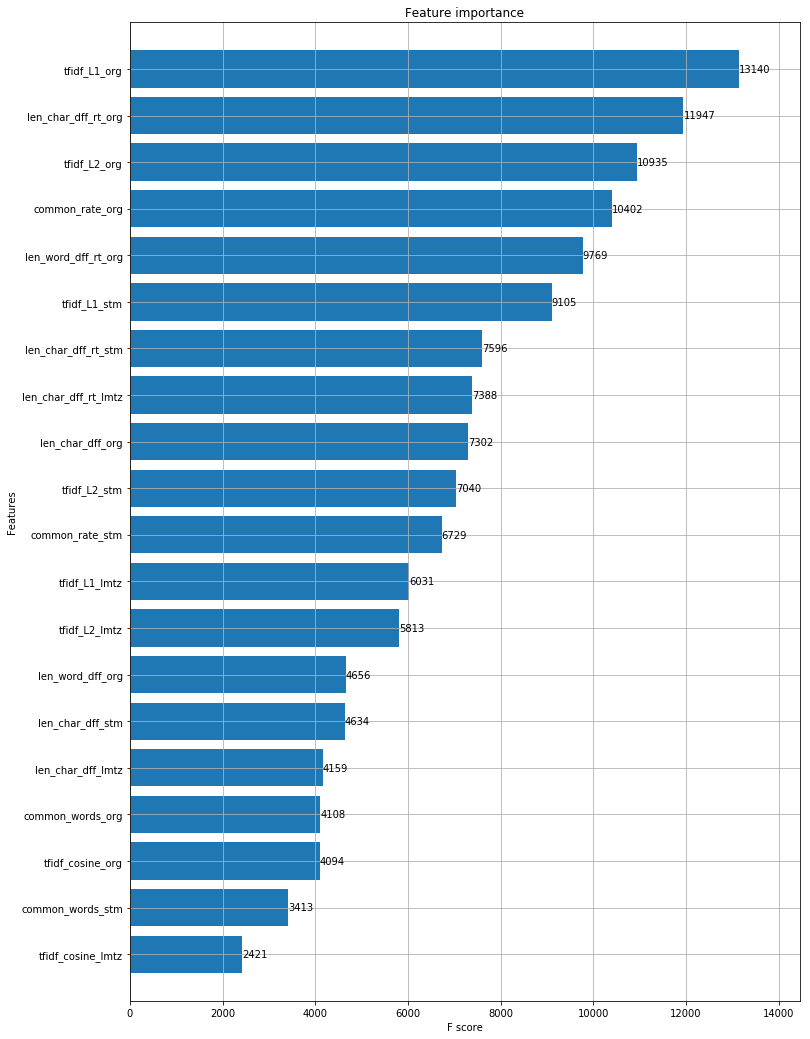

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
download_from_GCS('encode_ft_train.csv')
download_from_GCS('encode_ft_test.csv')

encode_ft_train.csv downloaded
encode_ft_test.csv downloaded


In [0]:
encode_ft_train = pd.read_csv('encode_ft_train.csv')
encode_ft_test = pd.read_csv('encode_ft_test.csv')
encode_ft_train.head()

,encode_L1,encode_L2,encode_cos
0,2.133778,0.269064,0.963802
1,3.548461,0.724755,0.737365
2,2.765091,0.456800,0.895667
3,4.717258,1.238057,0.233607
4,4.118772,0.973915,0.525745


In [0]:
train_ft2 = pd.concat([train_ft, encode_ft_train], axis=1)
train_ft2.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745


In [0]:
encode_ft_test = encode_ft_test.iloc[:, 1:encode_ft_test.shape[1]]
test_ft2 = pd.concat([test_ft, encode_ft_test], axis=1)
test_ft2.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7324d16ef0>,
      dtype=object)

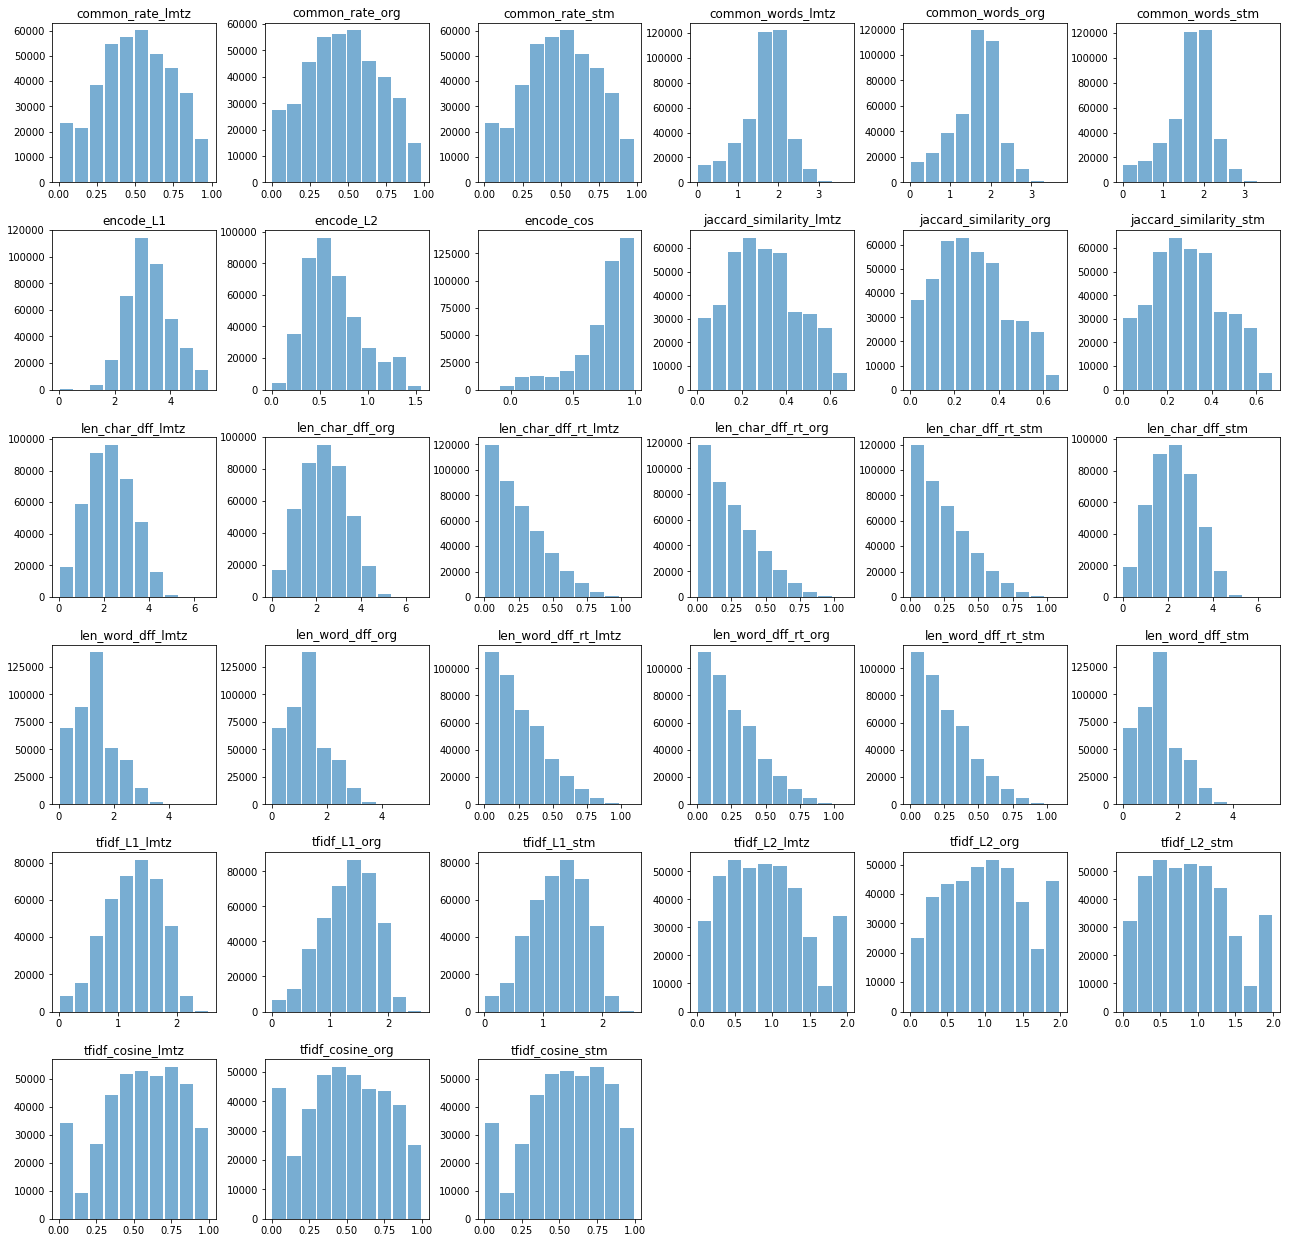

In [0]:
train_ft2.hist(rwidth=0.9, grid=False, figsize=(22, 22), alpha=0.6)

In [0]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train2, X_val2, y_train2, y_val2 = train_test_split(train_ft2, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test2 = test_ft2

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [0]:

clf2 = DecisionTreeClassifier(random_state=0)
start = time()
clf2.fit(X_train2, y_train2)
end = time()
train_time = end - start

start = time()
predictions_val = clf2.predict(X_val2)
predictions_train = clf2.predict(X_train2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 16.7550311088562 s
predict time: 0.17735052108764648 s
train set log_loss: 0.0058734543471974255
val set log_loss: 10.073678237559808


In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
start = time()
rf.fit(X_train2, y_train2)
end = time()
train_time = end - start

start = time()
predictions_val = rf.predict(X_val2)
predictions_train = rf.predict(X_train2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))

train time: 18.494015216827393 s
predict time: 1.516099452972412 s
train set log_loss: 0.41220511192051673
val set log_loss: 8.535891292283667


In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain2 = xgb.DMatrix(X_train2, label = y_train2)
dtrain2_p = xgb.DMatrix(X_train2)
dval2 = xgb.DMatrix(X_val2)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model2 = xgb.train(params, dtrain2, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model2.predict(dtrain2_p)
predictions_val = model2.predict(dval2)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train2, predictions_train)
log_loss_val = log_loss(y_val2, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.19288873672485 s
predict time: 0.3284938335418701 s
train set log_loss: 0.45540924192514926
val set log_loss: 0.49056796546472436


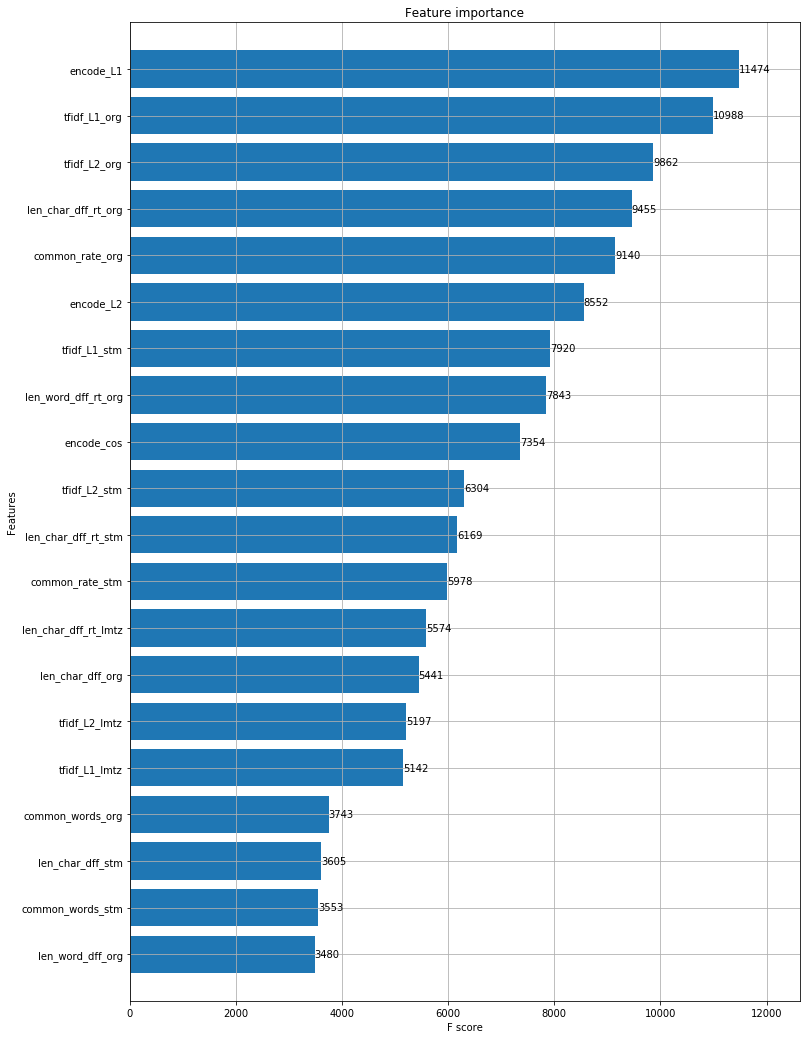

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model2, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
encode_ft_train2 = train_ft2.loc[:, ['encode_L1', 'encode_L2', 'encode_cos']]
encode_ft_test2 = test_ft2.loc[:, ['encode_L1', 'encode_L2', 'encode_cos']]
# 对于倾斜的数据使用Log转换
skewed = ['encode_cos']
encode_ft_train2[skewed] = encode_ft_train2[skewed].progress_apply(lambda x: np.log(x + 1))
encode_ft_test2[skewed] = encode_ft_test2[skewed].progress_apply(lambda x: np.log(x + 1))
encode_cos_log_train = encode_ft_train2[skewed].rename(columns=lambda x: x + '_log')
encode_cos_log_test = encode_ft_test2[skewed].rename(columns=lambda x: x + '_log')
encode_cos_log_train.head()

,encode_cos_log
0,0.674883
1,0.552370
2,0.639571
3,0.209942
4,0.422483


In [0]:
train_ft3 = pd.concat([train_ft2, encode_cos_log_train], axis=1)
train_ft3.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483


In [0]:
test_ft3 = pd.concat([test_ft2, encode_cos_log_test], axis=1)
test_ft3.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606,0.526269
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775,0.631684
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988,0.615720
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030,0.539430
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429,0.469021


In [0]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train3, X_val3, y_train3, y_val3 = train_test_split(train_ft3, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test3 = test_ft3

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [0]:

dt3 = DecisionTreeClassifier(random_state=0)
start = time()
dt3.fit(X_train3, y_train3)
end = time()
train_time = end - start

start = time()
predictions_val = dt3.predict(X_val3)
predictions_train = dt3.predict(X_train3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 17.701503038406372 s
predict time: 0.18323588371276855 s
train set log_loss: 0.0058734543471974255
val set log_loss: 10.067697871230289


In [0]:

rf3 = RandomForestClassifier()
start = time()
rf3.fit(X_train3, y_train3)
end = time()
train_time = end - start

start = time()
predictions_val = rf3.predict(X_val3)
predictions_train = rf3.predict(X_train3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 18.671452283859253 s
predict time: 1.4328324794769287 s
train set log_loss: 0.42138895385056274
val set log_loss: 8.596547947321557


In [0]:
#添加 feature encode_cos_log
dtrain3 = xgb.DMatrix(X_train3, label = y_train3)
dtrain3_p = xgb.DMatrix(X_train3)
dval3 = xgb.DMatrix(X_val3)


start = time()
model3 = xgb.train(params, dtrain3, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model3.predict(dtrain3_p)
predictions_val = model3.predict(dval3)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train3, predictions_train)
log_loss_val = log_loss(y_val3, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.80988264083862 s
predict time: 0.32914066314697266 s
train set log_loss: 0.45542891204586694
val set log_loss: 0.49051744886523946


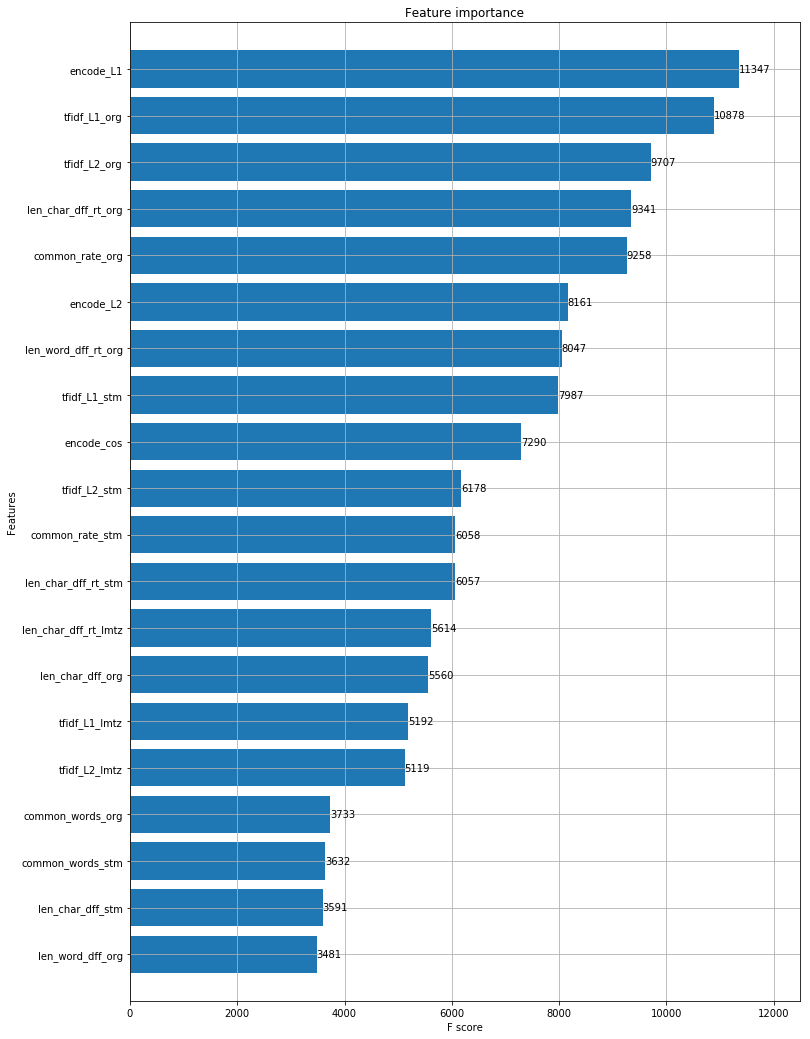

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model3, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
# 去除未log的encode_cos
X_train4 = X_train3.drop('encode_cos',axis=1)
X_val4 = X_val3.drop('encode_cos',axis=1)
X_test4 = X_test3.drop('encode_cos',axis=1)

y_train4 = y_train3
y_val4 = y_val3

#添加 feature encode_cos_log
dtrain4 = xgb.DMatrix(X_train4, label = y_train4)
dtrain4_p = xgb.DMatrix(X_train4)
dval4 = xgb.DMatrix(X_val4)


start = time()
model4 = xgb.train(params, dtrain4, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model4.predict(dtrain4_p)
predictions_val = model4.predict(dval4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.23064208030701 s
predict time: 0.32830333709716797 s
train set log_loss: 0.45547640247924576
val set log_loss: 0.49058923020274586


In [0]:
download_from_GCS('x_train_tk_stwd_ft.csv')
download_from_GCS('x_test_tk_stwd_ft.csv')

x_train_tk_stwd_ft.csv downloaded
x_test_tk_stwd_ft.csv downloaded


In [0]:
train_ft_stwd = pd.read_csv('x_train_tk_stwd_ft.csv')
test_ft_stwd = pd.read_csv('x_test_tk_stwd_ft.csv')
train_ft_stwd.head()

,id,question1,question2,common_words,common_rate,jaccard_similarity,tfidf_L1,tfidf_L2,tfidf_cosine
0,0,step step guide invest share market india,step step guide invest share market,5.0,0.833333,0.714286,0.228000,0.036422,0.981789
1,1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,4.0,0.500000,0.333333,2.010116,0.475765,0.762118
2,2,increase speed internet connection using vpn,internet speed increased hacking dns,2.0,0.333333,0.200000,3.179522,1.447160,0.276420
3,3,mentally lonely solve,find remainder math 23 24 math divided 24 23,0.0,0.000000,0.000000,4.029625,2.000000,0.000000
4,4,one dissolve water quickly sugar salt methane ...,fish would survive salt water,2.0,0.250000,0.142857,4.203730,1.504143,0.247928


In [0]:
test_ft_stwd.head()

,test_id,question1,question2,common_words,common_rate,jaccard_similarity,tfidf_L1,tfidf_L2,tfidf_cosine
0,0,surface pro 4 compare ipad pro,microsoft choose core m3 core i3 home surface ...,3.0,0.400000,0.250000,3.426962,1.332189,0.333906
1,1,hair transplant age 24 much would cost,much cost hair transplant require,4.0,0.615385,0.444444,1.718887,0.661058,0.669471
2,2,best way send money china america,send money china,3.0,0.600000,0.428571,1.344621,0.390172,0.804914
3,3,food emulsifiers,foods fibre,0.0,0.000000,0.000000,2.732294,2.000000,0.000000
4,4,aberystwyth start reading,start reading,2.0,0.666667,0.500000,0.000000,0.000000,1.000000


In [0]:
train_ft_stwd = train_ft_stwd.rename(columns=lambda x: x + '_stwd')
test_ft_stwd = test_ft_stwd.rename(columns=lambda x: x + '_stwd')
train_ft_stwd.head()

,id_stwd,question1_stwd,question2_stwd,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd,tfidf_cosine_stwd
0,0,step step guide invest share market india,step step guide invest share market,5.0,0.833333,0.714286,0.228000,0.036422,0.981789
1,1,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,4.0,0.500000,0.333333,2.010116,0.475765,0.762118
2,2,increase speed internet connection using vpn,internet speed increased hacking dns,2.0,0.333333,0.200000,3.179522,1.447160,0.276420
3,3,mentally lonely solve,find remainder math 23 24 math divided 24 23,0.0,0.000000,0.000000,4.029625,2.000000,0.000000
4,4,one dissolve water quickly sugar salt methane ...,fish would survive salt water,2.0,0.250000,0.142857,4.203730,1.504143,0.247928


In [0]:
train_ft4 = pd.concat([train_ft3, train_ft_stwd.iloc[:, 3:8]], axis=1)
train_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883,5.0,0.833333,0.714286,0.228000,0.036422
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370,4.0,0.500000,0.333333,2.010116,0.475765
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571,2.0,0.333333,0.200000,3.179522,1.447160
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.0,0.000000,0.000000,4.029625,2.000000
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483,2.0,0.250000,0.142857,4.203730,1.504143


In [0]:
test_ft4 = pd.concat([test_ft3, test_ft_stwd.iloc[:, 3:8]], axis=1)
test_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.386294,0.215111,2.197225,0.148420,1.386294,0.250000,0.133531,1.719823,1.435170,0.282415,1.386294,0.215111,2.302585,0.173511,1.386294,0.250000,0.133531,1.734239,1.475020,0.262490,1.386294,0.215111,2.197225,0.157186,1.386294,0.250000,0.133531,1.689093,1.452190,0.273905,3.637099,0.784084,0.692606,0.526269,3.0,0.400000,0.250000,3.426962,1.332189
1,2.079442,0.510826,2.772589,0.296266,1.791759,0.454545,0.257829,1.312116,0.789032,0.605484,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.079442,0.510826,2.890372,0.336472,1.791759,0.454545,0.257829,1.318978,0.733234,0.633383,2.865691,0.488314,0.880775,0.631684,4.0,0.615385,0.444444,1.718887,0.661058
2,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.260385,0.601267,0.699367,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.259183,0.597581,0.701209,2.079442,0.552069,3.258097,0.533111,1.791759,0.526316,0.305382,1.284690,0.623996,0.688002,3.039441,0.545916,0.850988,0.615720,3.0,0.600000,0.428571,1.344621,0.390172
3,0.693147,0.251314,2.302585,0.396415,0.000000,0.000000,0.000000,1.449417,2.000000,0.000000,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,0.693147,0.251314,2.197225,0.405465,0.693147,0.250000,0.133531,1.233261,1.586042,0.206979,3.665707,0.754944,0.715030,0.539430,0.0,0.000000,0.000000,2.732294,2.000000
4,1.098612,0.336472,1.098612,0.076961,1.386294,0.545455,0.318454,0.676052,0.305440,0.847280,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,1.098612,0.336472,1.098612,0.087011,1.386294,0.545455,0.318454,0.747521,0.382070,0.808965,3.948551,0.896182,0.598429,0.469021,2.0,0.666667,0.500000,0.000000,0.000000


In [0]:
skewed = [ 'common_words_stwd', 'jaccard_similarity_stwd', 'tfidf_L1_stwd']
train_ft4[skewed] = train_ft4[skewed].progress_apply(lambda x: np.log(x + 1))
test_ft4[skewed] = test_ft4[skewed].progress_apply(lambda x: np.log(x + 1))

In [0]:
train_ft4.head()

,len_word_dff_org,len_word_dff_rt_org,len_char_dff_org,len_char_dff_rt_org,common_words_org,common_rate_org,jaccard_similarity_org,tfidf_L1_org,tfidf_L2_org,tfidf_cosine_org,len_word_dff_stm,len_word_dff_rt_stm,len_char_dff_stm,len_char_dff_rt_stm,common_words_stm,common_rate_stm,jaccard_similarity_stm,tfidf_L1_stm,tfidf_L2_stm,tfidf_cosine_stm,len_word_dff_lmtz,len_word_dff_rt_lmtz,len_char_dff_lmtz,len_char_dff_rt_lmtz,common_words_lmtz,common_rate_lmtz,jaccard_similarity_lmtz,tfidf_L1_lmtz,tfidf_L2_lmtz,tfidf_cosine_lmtz,encode_L1,encode_L2,encode_cos,encode_cos_log,common_words_stwd,common_rate_stwd,jaccard_similarity_stwd,tfidf_L1_stwd,tfidf_L2_stwd
0,1.098612,0.143101,2.079442,0.134819,2.484907,0.916667,0.613104,0.308918,0.042975,0.978513,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,1.098612,0.143101,2.079442,0.137471,2.484907,0.916667,0.613104,0.336295,0.050317,0.974841,2.133778,0.269064,0.963802,0.674883,1.791759,0.833333,0.538997,0.205387,0.036422
1,1.791759,0.336472,3.496508,0.458575,2.079442,0.560000,0.328504,1.218322,0.499939,0.750030,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209643,0.486068,0.756966,1.791759,0.336472,3.367296,0.424157,2.079442,0.560000,0.328504,1.209611,0.486033,0.756984,3.548461,0.724755,0.737365,0.552370,1.609438,0.500000,0.287682,1.101979,0.475765
2,1.609438,0.287682,2.397895,0.169899,1.609438,0.320000,0.174353,1.667734,1.490253,0.254874,1.609438,0.287682,2.397895,0.189242,1.791759,0.400000,0.223144,1.512309,1.215205,0.392397,1.609438,0.287682,2.397895,0.192904,1.791759,0.400000,0.223144,1.512309,1.215203,0.392398,2.765091,0.456800,0.895667,0.639571,1.098612,0.333333,0.182322,1.430197,1.447160
3,1.098612,0.154151,2.302585,0.192078,0.000000,0.000000,0.000000,1.855883,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.859033,2.000000,0.000000,1.098612,0.154151,2.397895,0.233615,0.000000,0.000000,0.000000,1.860761,2.000000,0.000000,4.717258,1.238057,0.233607,0.209942,0.000000,0.000000,0.000000,1.615345,2.000000
4,1.945910,0.470004,3.433987,0.493658,1.609438,0.380952,0.211309,1.674485,1.443889,0.278056,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,1.945910,0.470004,3.367296,0.483797,1.609438,0.380952,0.211309,1.671665,1.428437,0.285782,4.118772,0.973915,0.525745,0.422483,1.098612,0.250000,0.133531,1.649376,1.504143


In [0]:

# 将'train_ft'和'train_label'切分为训练集和验证集
X_train4, X_val4, y_train4, y_val4 = train_test_split(train_ft4, train_label, test_size=0.2, random_state=0,
                                                    stratify = train_label)

X_test4 = test_ft4

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 323432 samples.
Validation set has 80858 samples.
Testing set has 2345796 samples.


In [0]:

dt4 = DecisionTreeClassifier(random_state=0)
start = time()
dt4.fit(X_train4, y_train4)
end = time()
train_time = end - start

start = time()
predictions_val = dt4.predict(X_val4)
predictions_train = dt4.predict(X_train4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 19.813995122909546 s
predict time: 0.18416452407836914 s
train set log_loss: 0.005553076873193978
val set log_loss: 9.52905081133901


In [0]:

rf4 = RandomForestClassifier()
start = time()
rf4.fit(X_train4, y_train4)
end = time()
train_time = end - start

start = time()
predictions_val = rf4.predict(X_val4)
predictions_train = rf4.predict(X_train4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 21.75764513015747 s
predict time: 1.4590301513671875 s
train set log_loss: 0.37472234427055556
val set log_loss: 8.218514088132489


In [0]:
#添加 removing stop words features
dtrain4 = xgb.DMatrix(X_train4, label = y_train4)
dtrain4_p = xgb.DMatrix(X_train4)
dval4 = xgb.DMatrix(X_val4)


start = time()
model4 = xgb.train(params, dtrain4, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model4.predict(dtrain4_p)
predictions_val = model4.predict(dval4)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train4, predictions_train)
log_loss_val = log_loss(y_val4, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 38.56170606613159 s
predict time: 0.340747594833374 s
train set log_loss: 0.4307283409043428
val set log_loss: 0.4679220610692612


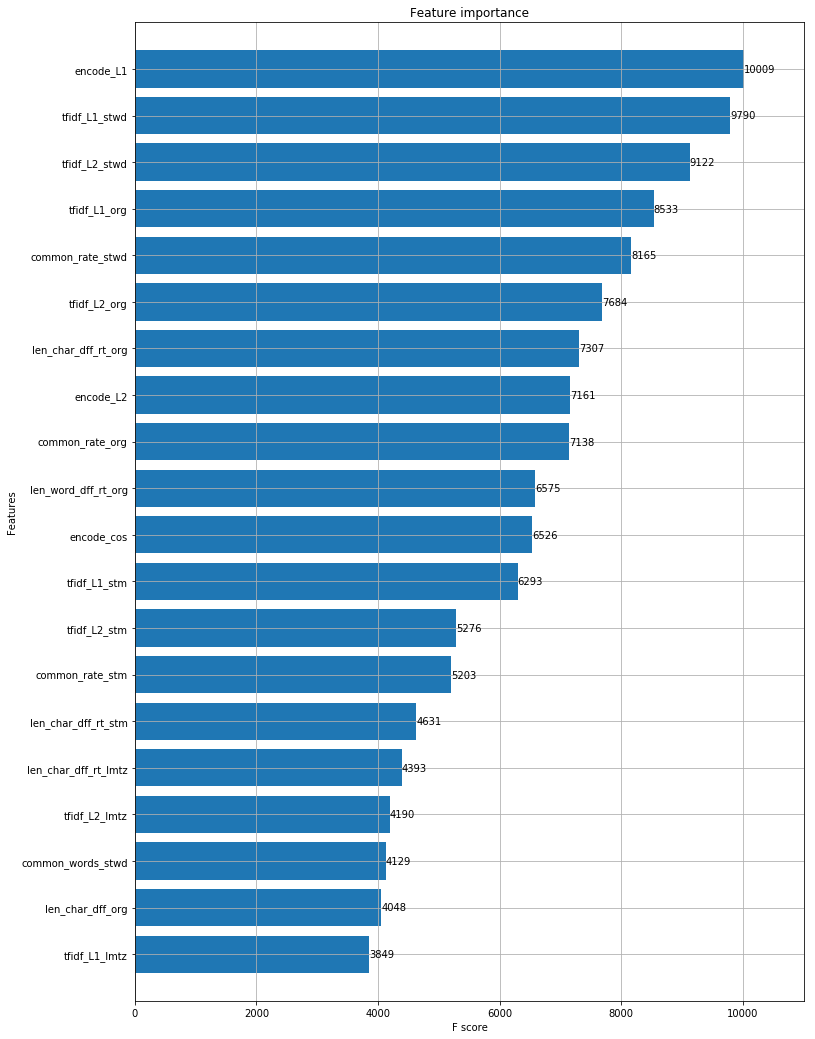

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model4, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
# 去除未 stm lmtz

drop_features = ['len_word_dff_stm', 'len_word_dff_rt_stm', 'len_char_dff_stm', 'len_char_dff_rt_stm', 
          'common_words_stm', 'common_rate_stm','jaccard_similarity_stm', 'tfidf_L1_stm', 'tfidf_L2_stm','tfidf_cosine_stm',
         'len_word_dff_lmtz', 'len_word_dff_rt_lmtz', 'len_char_dff_lmtz', 'len_char_dff_rt_lmtz', 
          'common_words_lmtz', 'common_rate_lmtz','jaccard_similarity_lmtz', 'tfidf_L1_lmtz', 'tfidf_L2_lmtz','tfidf_cosine_lmtz']

X_train5 = X_train4.drop(drop_features,axis=1)
X_val5 = X_val4.drop(drop_features,axis=1)
X_test5 = X_test4.drop(drop_features,axis=1)

y_train5 = y_train4
y_val5 = y_val4

#添加 feature encode_cos_log
dtrain5 = xgb.DMatrix(X_train5, label = y_train5)
dtrain5_p = xgb.DMatrix(X_train5)
dval5 = xgb.DMatrix(X_val5)


start = time()
model5 = xgb.train(params, dtrain5, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model5.predict(dtrain5_p)
predictions_val = model5.predict(dval5)
end = time()
predict_time = end - start

log_loss_train = log_loss(y_train5, predictions_train)
log_loss_val = log_loss(y_val5, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))


train time: 33.259767293930054 s
predict time: 0.19637703895568848 s
train set log_loss: 0.4446031518971855
val set log_loss: 0.4776364562664587


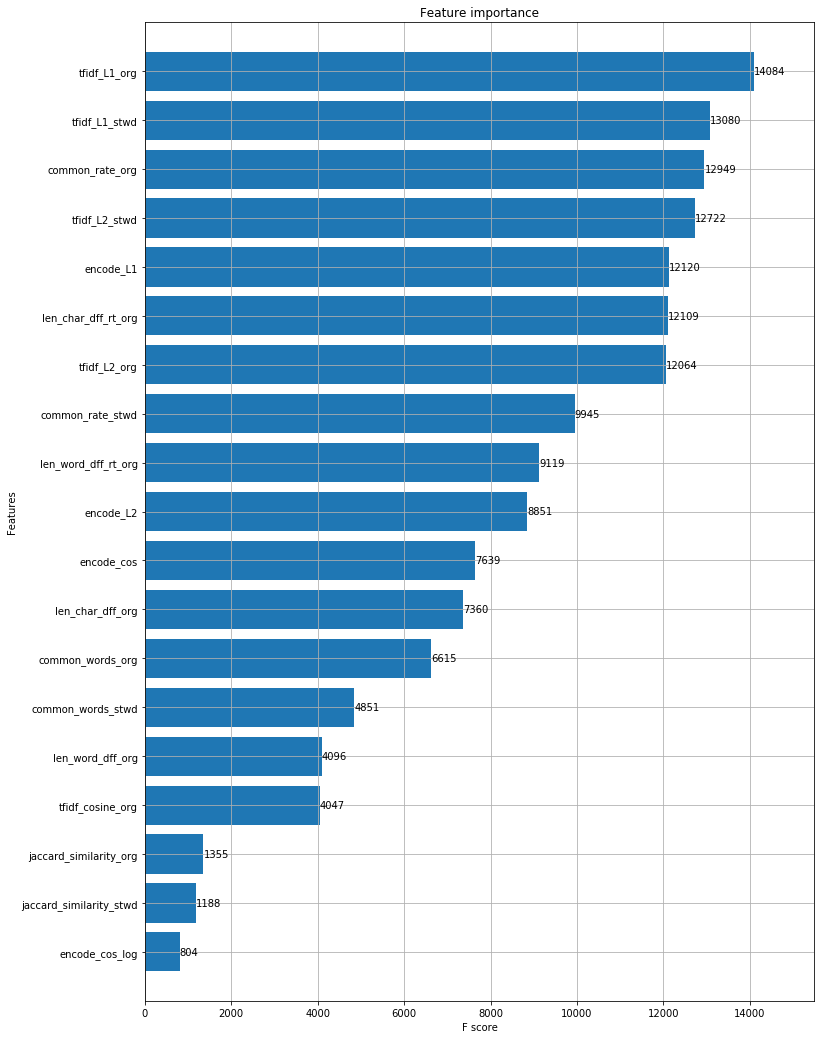

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model5, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [0]:
train_ft4.to_csv('train_ft_all.csv', index=False)
test_ft4.to_csv('test_ft_all.csv', index=False)
upload_to_GCS('train_ft_all.csv')
upload_to_GCS('test_ft_all.csv')

train_ft_all.csv uploaded
test_ft_all.csv uploaded


In [0]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

dtrain = xgb.DMatrix(X_train, label = y_train)
dtrain_p = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)

params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

start = time()
model = xgb.train(params, dtrain, num_boost_round = 3600)
end = time()
train_time = end - start

start = time()
predictions_train = model.predict(dtrain_p)
predictions_val = model.predict(dval)
end = time()
predict_time = end - start


In [0]:
log_loss_train = log_loss(y_train, predictions_train)
log_loss_val = log_loss(y_val, predictions_val)

print("train time: {} s".format(train_time))
print("predict time: {} s".format(predict_time))
print("train set log_loss: {}".format(log_loss_train))
print("val set log_loss: {}".format(log_loss_val))

train time: 312.60965275764465 s
predict time: 1.0736591815948486 s
train set log_loss: 0.5221338658375846
val set log_loss: 0.5563620702769658
